<a href="https://colab.research.google.com/github/Nyamu007/ML-PROJECTS/blob/main/Image_Detection_One.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
pip install mlflow

In [12]:
pip install torch matplotlib numpy pandas

In [13]:
pip install pytorch_lightning

In [14]:
pip install pyngrok

In [15]:
# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background


# create remote tunnel using ngrok.com to allow local port access
from pyngrok import ngrok

# Terminate open tunnels if they exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2hT264EcQhHuyMKxO2Yp3GNtznG_2Z1K42GRvHJ1cwYkA7Bhq"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr = "5000", proto = "http", bind_tls = True)

print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://9c66-35-247-135-196.ngrok-free.app


In [16]:
import mlflow
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [17]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
emnist_train_data  = pd.read_csv(r'/content/drive/MyDrive/emnist-letters-train.csv')
emnist_test_data  = pd.read_csv(r'/content/drive/MyDrive/emnist-letters-test.csv')
emnist_train_data.head(10)

,23,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.406,0.407,0.408,0.409,0.410,0.411,0.412,0.413,0.414,0.415
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
emnist_train_data.describe()

,23,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.406,0.407,0.408,0.409,0.410,0.411,0.412,0.413,0.414,0.415
count,88799.000000,88799.0,88799.0,88799.0,88799.000000,88799.000000,88799.000000,88799.000000,88799.000000,88799.000000,...,88799.0,88799.0,88799.0,88799.000000,88799.000000,88799.0,88799.0,88799.0,88799.0,88799.0
mean,13.519161,0.0,0.0,0.0,0.000011,0.003987,0.016757,0.024640,0.021487,0.017140,...,0.0,0.0,0.0,0.003041,0.000360,0.0,0.0,0.0,0.0,0.0
std,7.502906,0.0,0.0,0.0,0.003356,0.544042,1.547695,1.915987,1.803280,1.620203,...,0.0,0.0,0.0,0.823450,0.107386,0.0,0.0,0.0,0.0,0.0
min,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,7.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,14.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,20.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,26.000000,0.0,0.0,0.0,1.000000,107.000000,213.000000,217.000000,214.000000,216.000000,...,0.0,0.0,0.0,244.000000,32.000000,0.0,0.0,0.0,0.0,0.0


In [20]:
emnist_test_data = emnist_test_data.sample(frac = 1)

emnist_test_data.head(10)

,1,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.548,0.549,0.550,0.551,0.552,0.553,0.554,0.555,0.556,0.557
6452,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12082,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9255,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1627,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8609,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7392,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6040,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13962,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14652,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8816,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
classes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
           'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

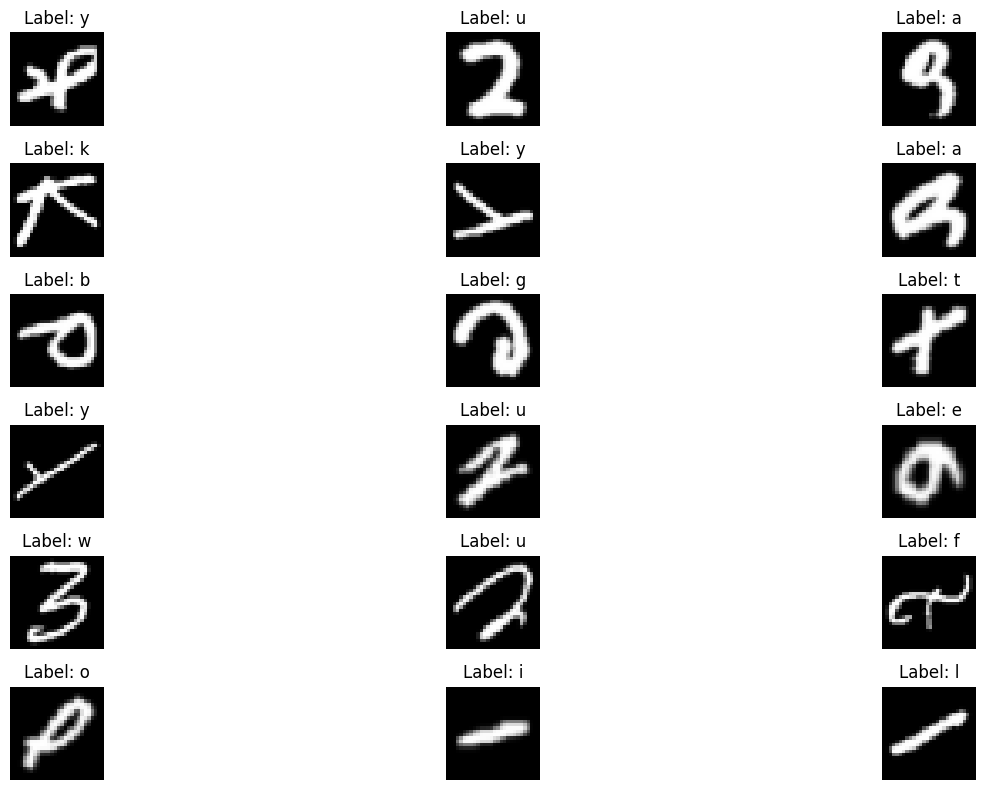

In [22]:
# Assuming the first column contains labels and the rest are pixel values
train_labels = emnist_train_data.values[:, 0]
train_images = emnist_train_data.values[:, 1:]

# Reshape the images to (num_samples, 28, 28)
train_images = train_images.reshape(-1, 28, 28)

# Display a few random images
num_samples = 18

random_indices = np.random.randint(0, len(train_images), num_samples)

random_indices

fig = plt.figure(figsize = (16, 8))

for i, idx in enumerate(random_indices):
    plt.subplot(6, int(num_samples / 6), i+1)
    plt.imshow(train_images[idx] / 255.0, cmap = "gray")
    plt.title(f"Label: {classes[int(train_labels[idx] - 1)]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [23]:
experiment_id = mlflow.create_experiment(name = 'test_experiment')

experiment_id

'119995403446652647'

In [24]:
experiment = mlflow.get_experiment(experiment_id)

print("Name: {}".format(experiment.name))
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))
print("Creation timestamp: {}".format(experiment.creation_time))

Name: test_experiment
Experiment_id: 119995403446652647
Artifact Location: file:///content/mlruns/119995403446652647
Tags: {}
Lifecycle_stage: active
Creation timestamp: 1717836448931


In [25]:
mlflow.set_experiment(experiment_name = 'test_experiment')

<Experiment: artifact_location='file:///content/mlruns/119995403446652647', creation_time=1717836448931, experiment_id='119995403446652647', last_update_time=1717836448931, lifecycle_stage='active', name='test_experiment', tags={}>

In [26]:
mlflow.start_run()

mlflow.end_run()

In [27]:
data_info = """
  The EMNIST dataset is a set of handwritten character digits derived
  from the NIST Special Database 19  and converted to a 28x28 pixel image format and dataset
  structure that directly matches the MNIST dataset.
  Further information on the dataset contents and conversion process can be found in
  the paper available at https://arxiv.org/abs/1702.05373v1.
"""

with open("data_info.txt", "w") as f:
    f.write(data_info)

In [28]:
with mlflow.start_run(run_name = 'test_experiment_run') as current_run:

    mlflow.log_metric('Accuracy', 0.67)

    params = {
        'num_nn_layers': 4
    }
    mlflow.log_params(params)

    mlflow.log_figure(fig, 'sample_images.png')

    mlflow.log_artifact("data_info.txt")

    mlflow.set_tag('EMNIST', 'Classification using DNNs')

In [29]:
class EMNISTDataset(Dataset):
    def __init__(self, dataframe):

        self.images = torch.tensor(dataframe.iloc[:, 1:].values, dtype= torch.float32)

        self.labels = torch.tensor(dataframe.iloc[:, 0].values, dtype = torch.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        images = self.images[idx]

        images = images / 255.0
        labels = self.labels[idx]

        return images, labels

In [30]:
train_dataset = EMNISTDataset(emnist_train_data)

test_dataset = EMNISTDataset(emnist_test_data )

len(train_dataset), len(test_dataset)

(88799, 14799)

In [31]:
from torch.utils.data import random_split

val_percent = 0.1
val_len = int(val_percent * len(train_dataset))

train_ds, val_ds = random_split(train_dataset, [len(train_dataset) - val_len, val_len])

print(len(train_ds), len(val_ds))

79920 8879


In [32]:
batch_size = 64

train_dataloader = DataLoader(train_ds, batch_size, shuffle = True, drop_last = True, num_workers=1)

val_dataloader = DataLoader(val_ds, batch_size, num_workers=1)

test_dataloader = DataLoader(test_dataset, batch_size, num_workers=1)

len(train_dataloader), len(val_dataloader), len(test_dataloader)

(1248, 139, 232)

In [33]:
dataiter = iter(train_dataloader)
batch_images, batch_labels = next(dataiter)

batch_images

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [34]:
batch_labels

tensor([19., 18.,  2., 10., 13., 26.,  2., 15.,  1., 24.,  5.,  8., 24., 15.,
        17., 21., 22.,  4., 18.,  3.,  1., 25., 11.,  8., 17., 15., 12., 20.,
        19., 25.,  9., 22.,  5.,  4.,  5.,  8., 25., 19., 23., 16.,  2., 15.,
         9., 23., 21.,  9.,  5.,  5., 25., 13., 13.,  1.,  9., 16., 14.,  4.,
        26., 22., 10., 19.,  6., 24., 23., 25.])

In [35]:
batch_images.shape, len(batch_labels)

(torch.Size([64, 784]), 64)

In [36]:
import mlflow

experiment_id = mlflow.create_experiment(name = "emnist_letters_prediction_using_dnn")

mlflow.set_experiment(experiment_name = "emnist_letters_prediction_using_dnn")

<Experiment: artifact_location='file:///content/mlruns/801280321834758231', creation_time=1717836454235, experiment_id='801280321834758231', last_update_time=1717836454235, lifecycle_stage='active', name='emnist_letters_prediction_using_dnn', tags={}>

In [37]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl

from torchmetrics.functional import accuracy

In [38]:
input_size = 28 * 28

output_size = 26

In [39]:
class EmnistModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.criterion = nn.CrossEntropyLoss()

        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, 128)
        self.linear3 = nn.Linear(128, 32)
        self.linear4 = nn.Linear(32, output_size)

    def forward(self, xb):
        out = self.linear1(xb)
        out = F.relu(out)

        out = self.linear2(out)
        out = F.relu(out)

        out = self.linear3(out)
        out = F.relu(out)

        out = self.linear4(out)
        return out

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr = 0.0001)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y -= 1

        y_hat = self(x)
        loss = self.criterion(y_hat, y.long())
        pred = y_hat.argmax(dim = 1)

        acc = accuracy(pred, y, task = "multiclass", num_classes = 26)

        self.log("train_loss", loss, on_epoch = True, prog_bar = True)
        self.log("train_acc", acc, on_epoch = True, prog_bar = True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y -= 1

        y_hat = self(x)
        loss = self.criterion(y_hat, y.long())
        pred = y_hat.argmax(dim = 1)

        acc = accuracy(pred, y, task = "multiclass", num_classes = 26)

        self.log("valid_loss", loss, on_epoch = True, prog_bar = True)
        self.log("valid_acc", acc, on_epoch = True, prog_bar = True)

        return acc

    def test_step(self, batch, batch_idx):
        x, y = batch
        y -= 1

        y_hat = self(x)
        loss = self.criterion(y_hat, y.long())
        pred = y_hat.argmax(dim = 1)

        acc = accuracy(pred, y, task = "multiclass", num_classes = 26)

        self.log("test_loss", loss, logger = True)
        self.log("test_acc", acc, logger = True)

        return acc


    def predict_step(self, batch, batch_idx, dataloader_idx = 0):
        x, y = batch

        return self(x)

In [40]:
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import ColSpec, Schema, TensorSpec
from pytorch_lightning.loggers import CSVLogger

emnist_model = EmnistModel()

logger = CSVLogger("logs", name = "emnist_letters_classification")

trainer = pl.Trainer(max_epochs = 10, logger = logger)

mlflow.pytorch.autolog(log_models = False)

with mlflow.start_run() as run:

    trainer.fit(emnist_model, train_dataloader, val_dataloader)
    trainer.test(dataloaders = test_dataloader)

    input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 784))])
    output_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 26))])

    signature = ModelSignature(inputs = input_schema, outputs = output_schema)

    mlflow.pytorch.log_model(emnist_model, "emnist-letters-classifier-dnn-model", signature = signature)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
2024/06/08 08:47:43 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
2024/06/08 08:47:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/mlflow/pytorch/_lightning_autolog.py:463: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.9.0 and 2.2.4 and may not succeed with packages outside this range."
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pyt

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

2024/06/08 08:48:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Validation: |          | 0/? [00:00<?, ?it/s]

2024/06/08 08:48:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Validation: |          | 0/? [00:00<?, ?it/s]

2024/06/08 08:48:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Validation: |          | 0/? [00:00<?, ?it/s]

2024/06/08 08:48:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Validation: |          | 0/? [00:00<?, ?it/s]

2024/06/08 08:48:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Validation: |          | 0/? [00:00<?, ?it/s]

2024/06/08 08:49:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Validation: |          | 0/? [00:00<?, ?it/s]

2024/06/08 08:49:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Validation: |          | 0/? [00:00<?, ?it/s]

2024/06/08 08:49:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Validation: |          | 0/? [00:00<?, ?it/s]

2024/06/08 08:49:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Validation: |          | 0/? [00:00<?, ?it/s]

2024/06/08 08:50:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/emnist_letters_classification/version_0/checkpoints/epoch=9-step=12480.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.util

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8412730693817139     │
│         test_loss         │    0.5126314163208008     │
└───────────────────────────┴───────────────────────────┘

2024/06/08 08:50:03 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [41]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

metrics

,epoch,step,test_acc,test_loss,train_acc_epoch,train_acc_step,train_loss_epoch,train_loss_step,valid_acc,valid_loss
0,0,49,NaN,NaN,NaN,0.062500,NaN,3.209777,NaN,NaN
1,0,99,NaN,NaN,NaN,0.171875,NaN,3.067456,NaN,NaN
2,0,149,NaN,NaN,NaN,0.171875,NaN,2.814306,NaN,NaN
3,0,199,NaN,NaN,NaN,0.359375,NaN,2.518666,NaN,NaN
4,0,249,NaN,NaN,NaN,0.359375,NaN,2.232528,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
265,9,12399,NaN,NaN,NaN,0.796875,NaN,0.482195,NaN,NaN
266,9,12449,NaN,NaN,NaN,0.843750,NaN,0.652847,NaN,NaN
267,9,12479,NaN,NaN,NaN,NaN,NaN,NaN,0.858881,0.454298
268,9,12479,NaN,NaN,0.87008,NaN,0.429671,NaN,NaN,NaN


<Axes: xlabel='epoch'>

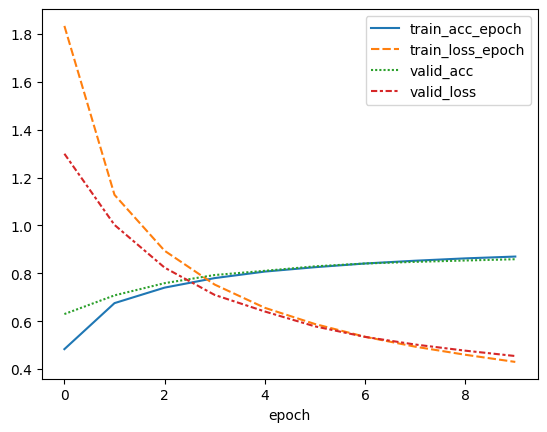

In [42]:
import seaborn as sns

# Set the epoch column as the index, for easier plotting
metrics.set_index("epoch", inplace = True)
metrics.drop(columns = ['step', 'train_loss_step',
                        'train_acc_step', 'test_acc', 'test_loss'], inplace = True)
# Create a line plot of the training metrics using Seaborn
sns.lineplot(data = metrics)

In [43]:
run_id = mlflow.last_active_run().info.run_id

run_id

'0370d2a5519a4528b4e6c25088a7ea1a'

In [44]:
test_dataiter = iter(test_dataloader)

test_imgs, test_labels = next(test_dataiter)

test_imgs.shape, test_labels.shape

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([64, 784]), torch.Size([64]))

In [45]:
logged_model = f"runs:/{run_id}/emnist-letters-classifier-dnn-model"

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

predictions = loaded_model.predict(test_imgs.numpy())

predictions[:5]

array([[ -7.126571  ,  -0.8939137 ,  -3.5856922 ,  -3.5380049 ,
          0.22820945,  -5.787104  ,  -3.8949308 ,  -9.123317  ,
          7.784184  ,   2.6601145 , -10.446743  ,   2.5061326 ,
        -17.914223  , -13.497919  , -10.335271  , -12.428898  ,
         -4.7426476 ,  -4.587327  ,   1.3778627 ,   0.68667364,
        -13.8987    , -11.428385  , -16.42523   ,  -3.2492914 ,
         -5.62443   ,   2.864594  ],
       [  1.298476  ,  -1.3468078 ,  -5.7406797 ,  -1.1574124 ,
         -1.7461128 ,   3.2227683 ,  -1.0357847 ,   0.8987491 ,
         -9.388778  ,  -7.3381534 ,  -1.6700373 ,  -8.194651  ,
         -2.3186827 ,   0.20919576,  -1.9944886 ,   3.8931746 ,
         -1.5300817 ,   2.0903761 ,  -4.515593  ,  -3.4665165 ,
         -3.6605098 ,  -0.57992315,  -2.6001596 ,  -3.95765   ,
         -3.480874  ,  -4.339488  ],
       [ -2.5798798 ,   0.94603854,  -3.6549869 ,  -0.620677  ,
         -2.3527114 ,  -2.6855474 ,  -6.4720087 ,   1.4487547 ,
          2.0328534 ,  -2.7794

In [46]:
test_labels[6].item()

8.0

In [47]:
classes[int(test_labels[6].item()) - 1]

'h'

In [48]:
predictions[6]

array([  1.3190134,   2.4698136, -12.108345 ,   2.8481596,  -6.2900395,
        -5.799156 ,  -4.735322 ,   7.8492503,  -8.582698 , -11.559633 ,
         5.347484 ,  -6.112676 ,  -1.406583 ,   2.5905426,  -8.213969 ,
        -9.3273535,  -6.116236 ,   0.9676331,  -8.978501 ,  -3.2582908,
        -5.185741 , -11.534862 ,  -0.7983949,   2.3860185,  -6.584896 ,
        -1.9490061], dtype=float32)

In [49]:
classes[np.argmax(predictions[6])]

'h'

In [50]:
def show(idx, title):

    plt.figure()
    plt.imshow(test_imgs[idx].numpy().reshape(28, 28), cmap = "gray")

    plt.axis("off")
    plt.title("\n\n{}".format(title), fontdict = {"size": 16})

<ipython-input-50-de63a52b775e>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


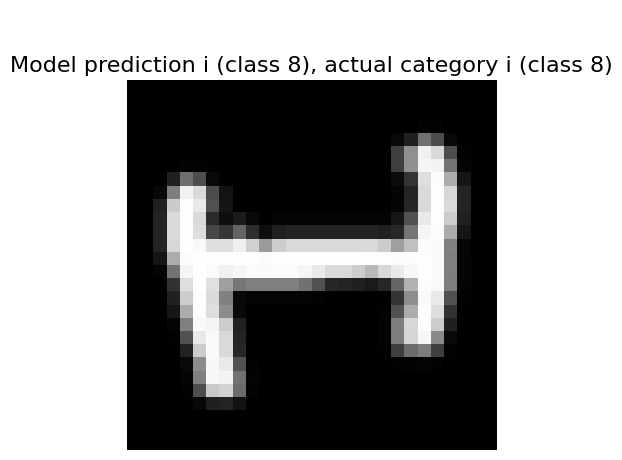

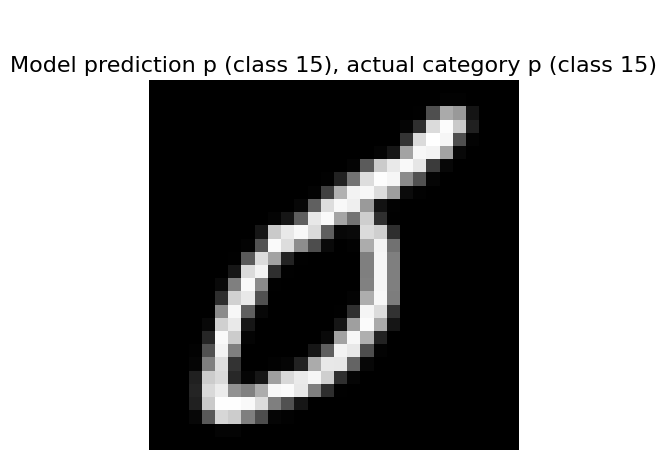

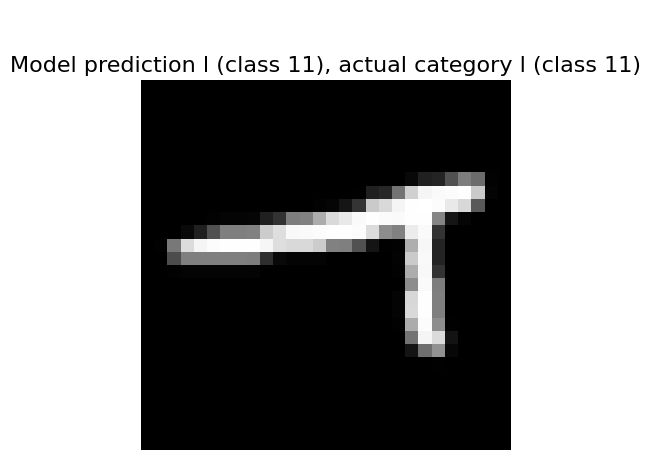

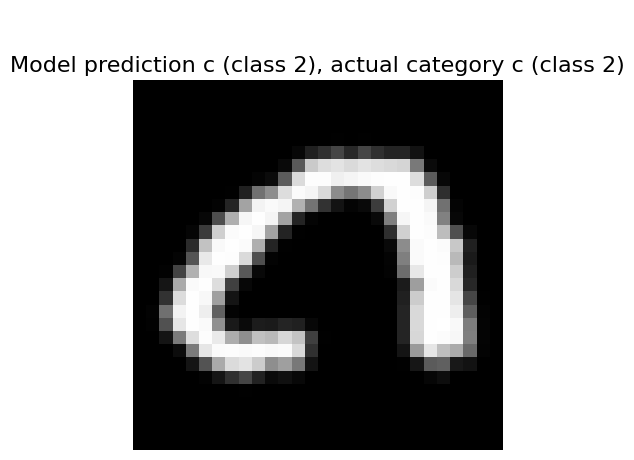

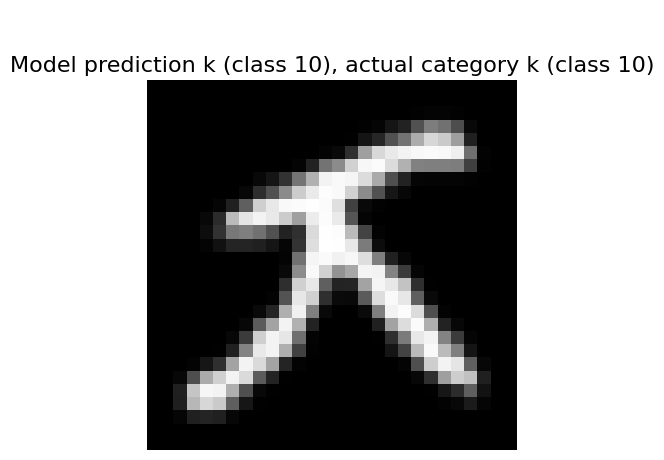

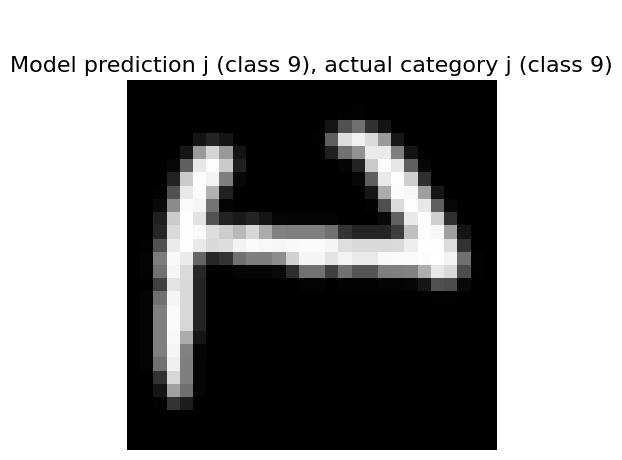

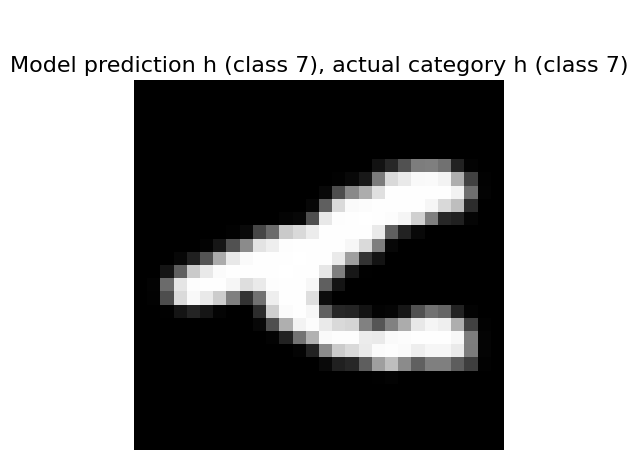

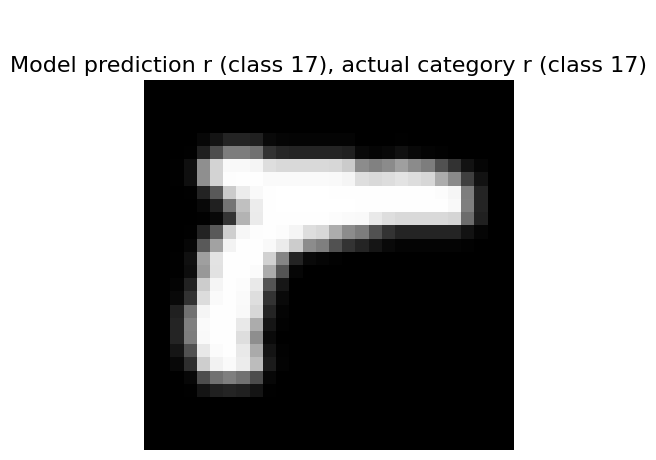

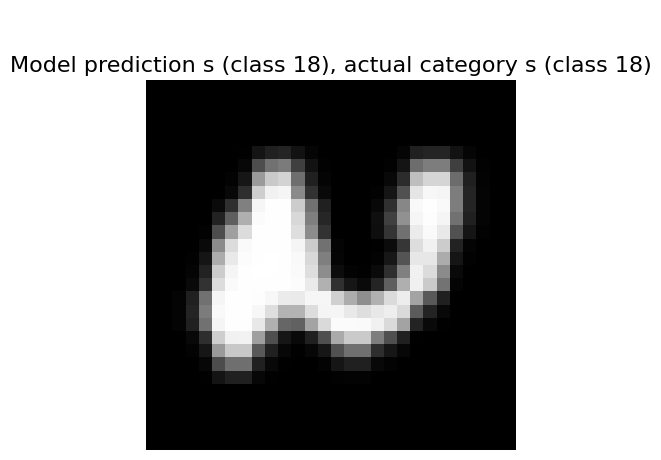

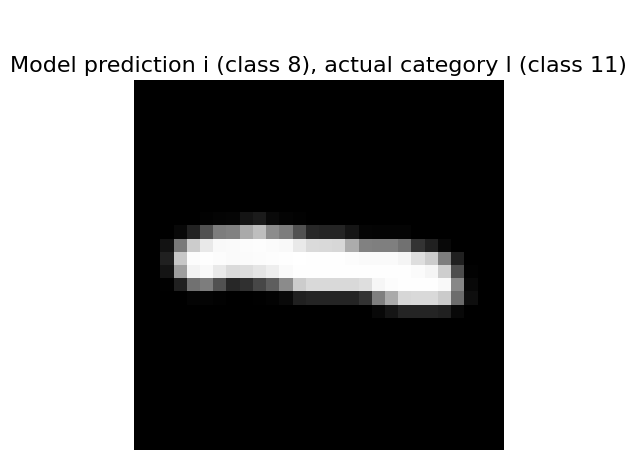

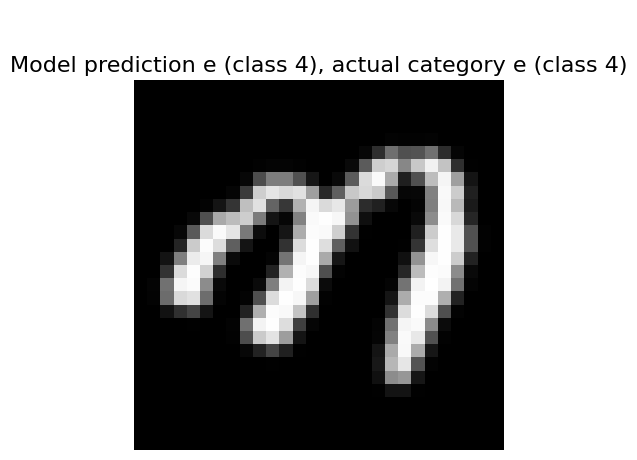

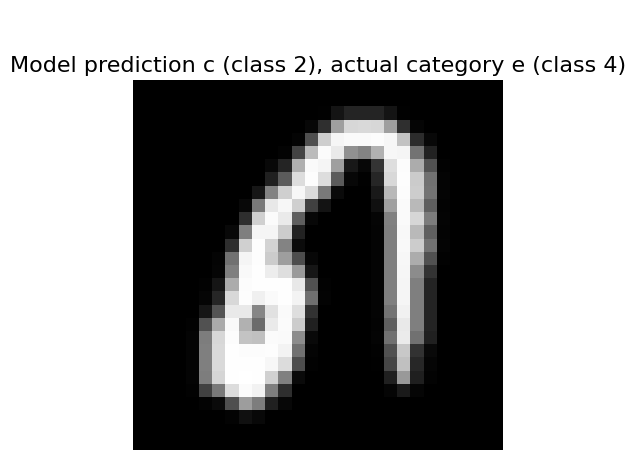

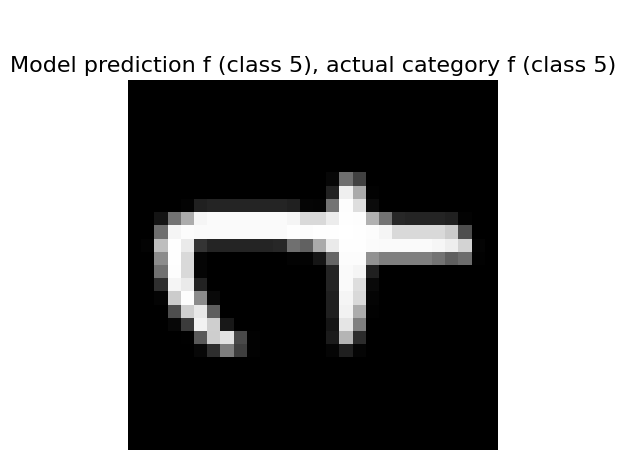

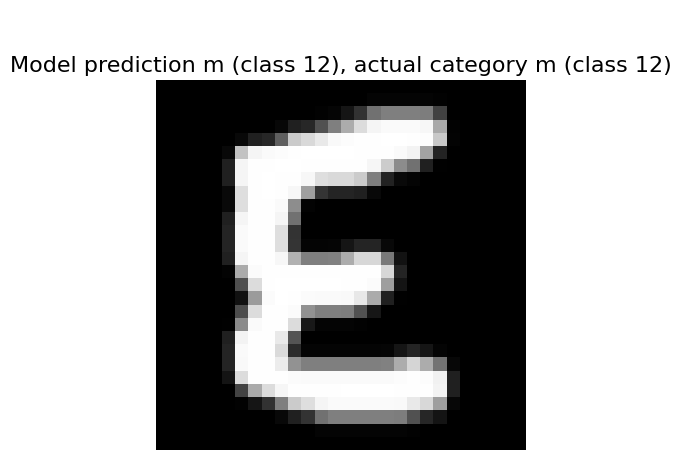

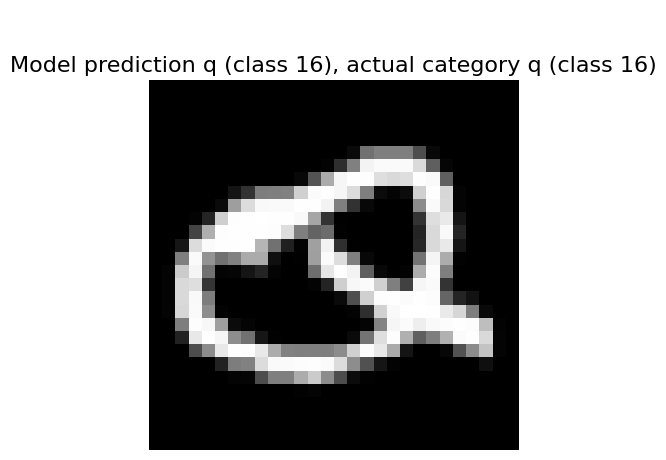

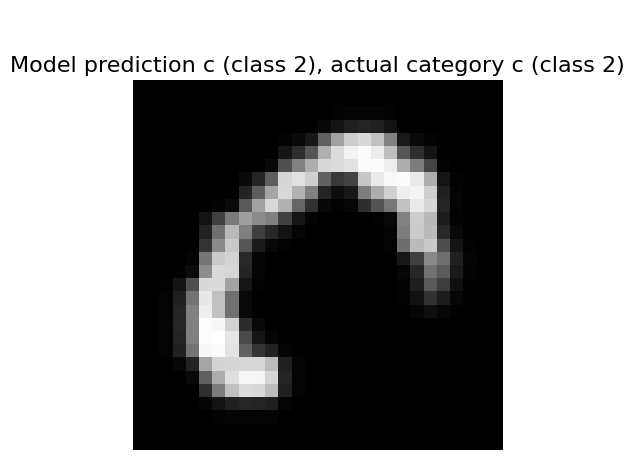

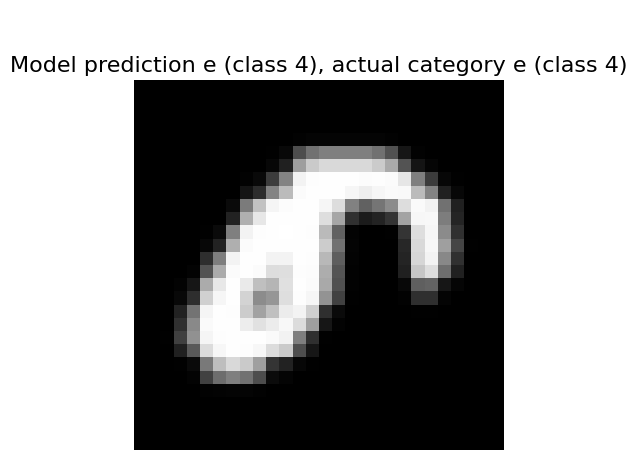

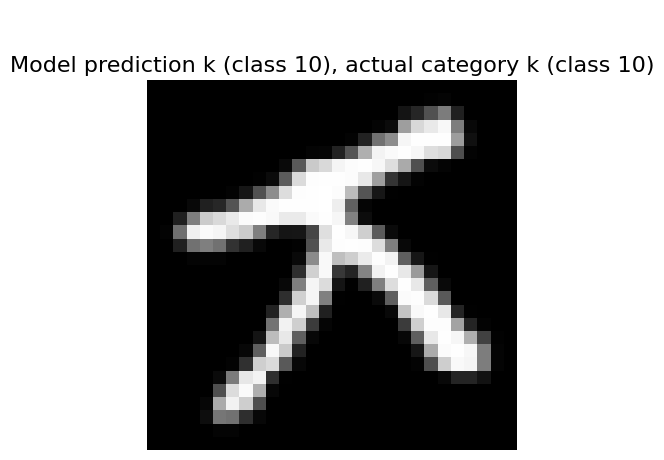

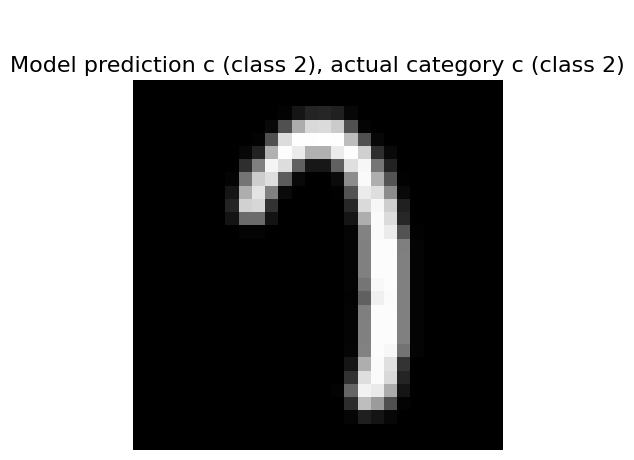

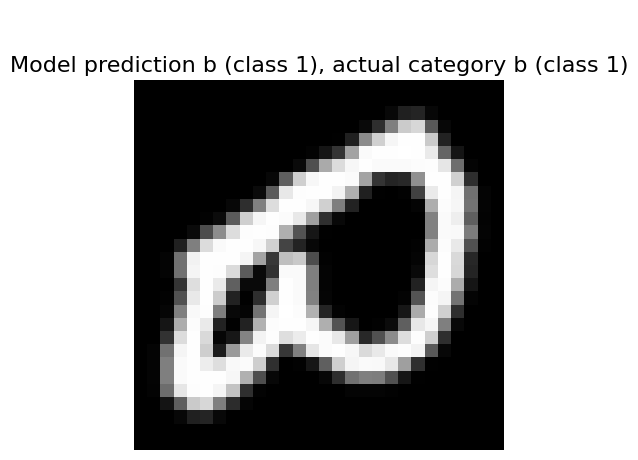

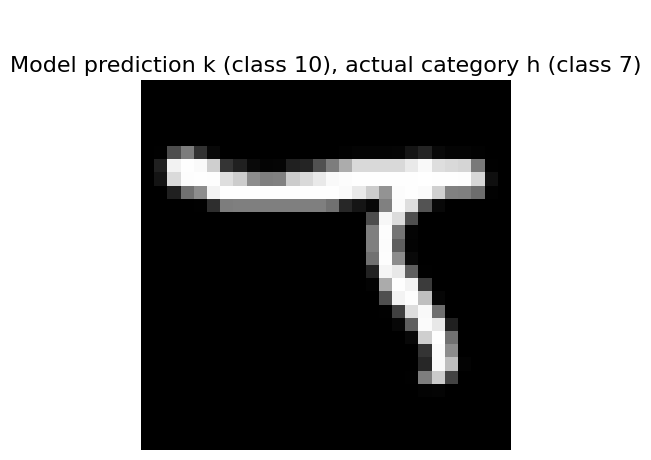

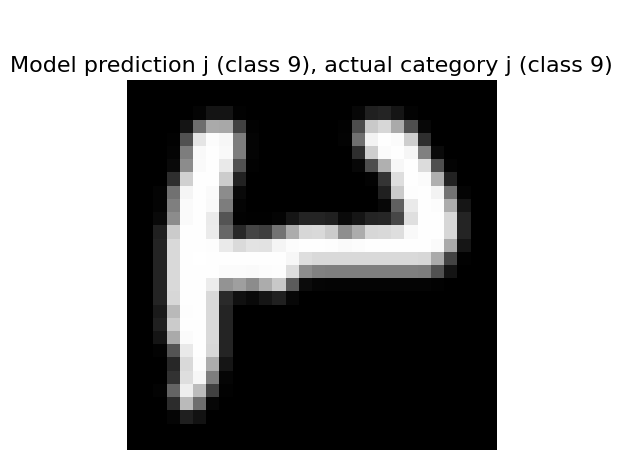

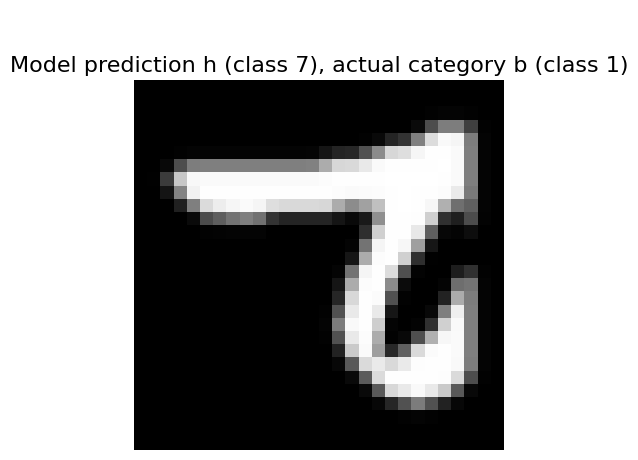

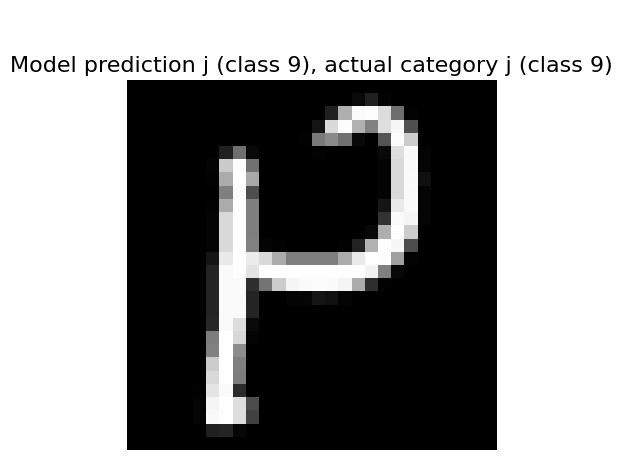

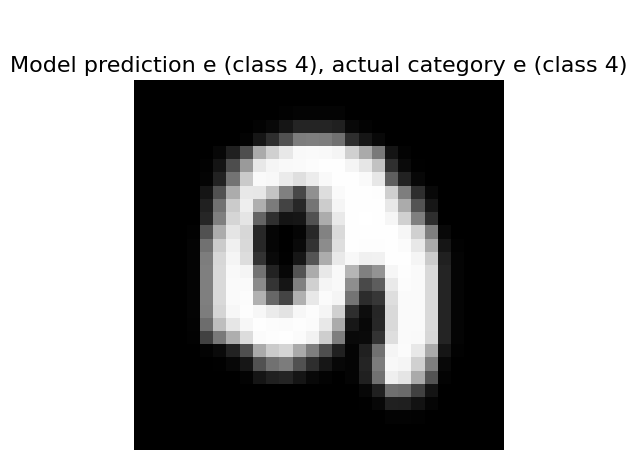

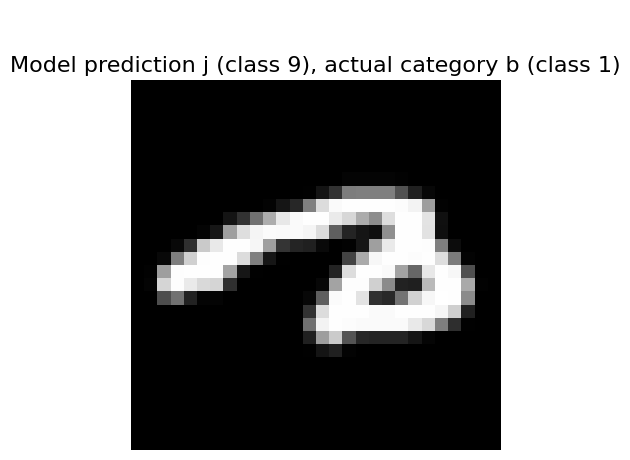

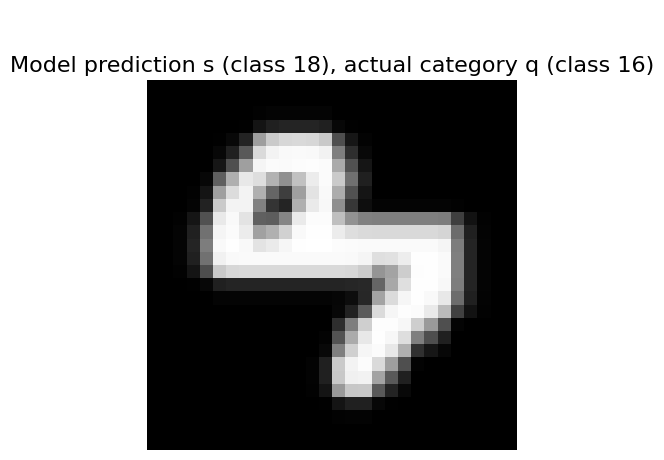

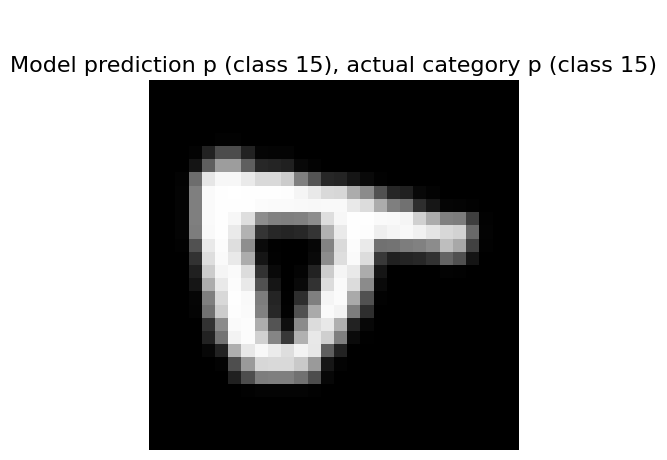

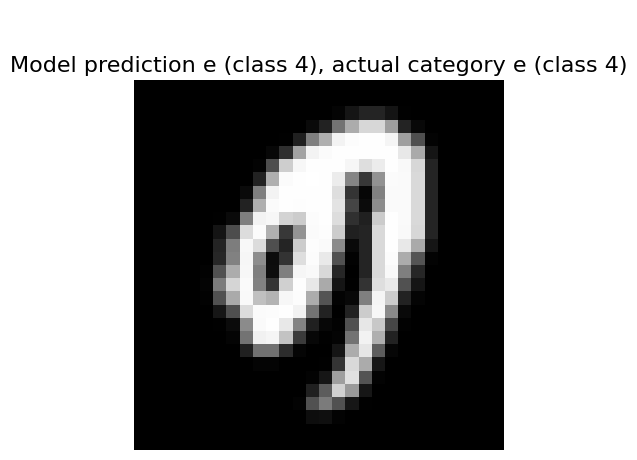

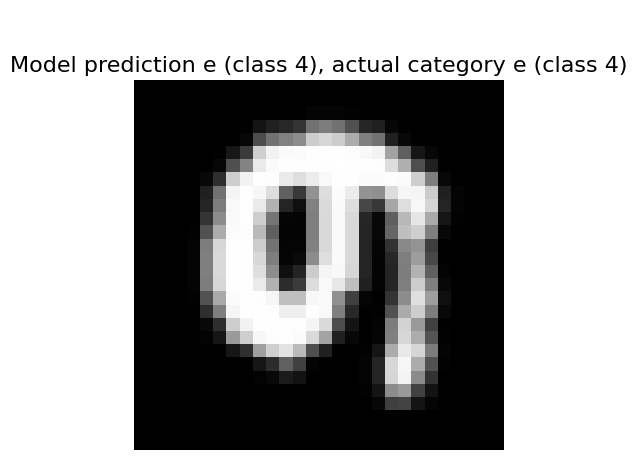

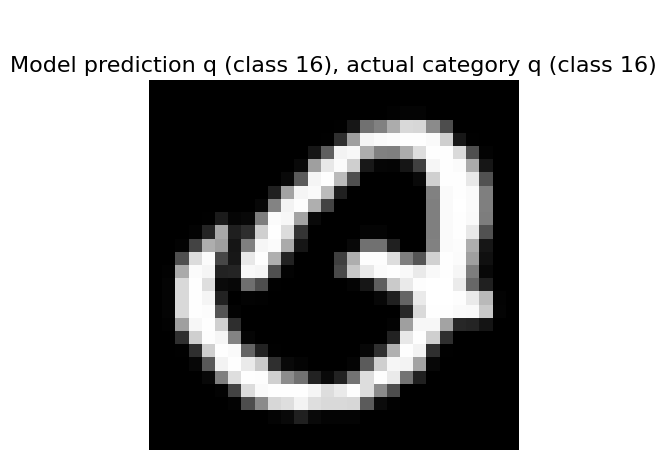

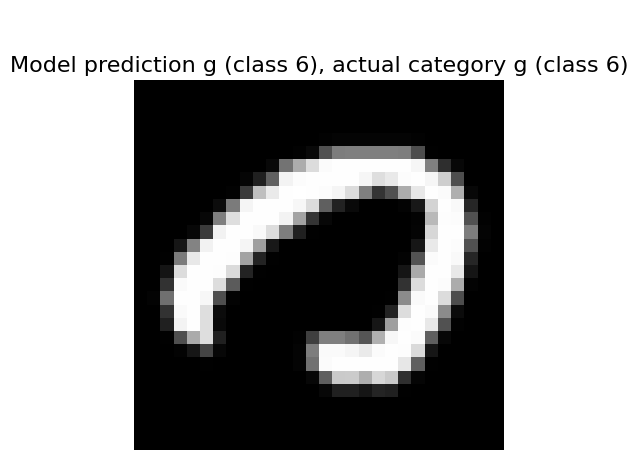

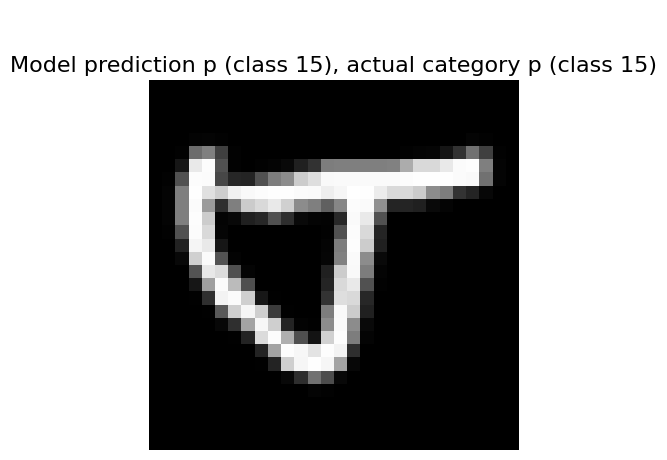

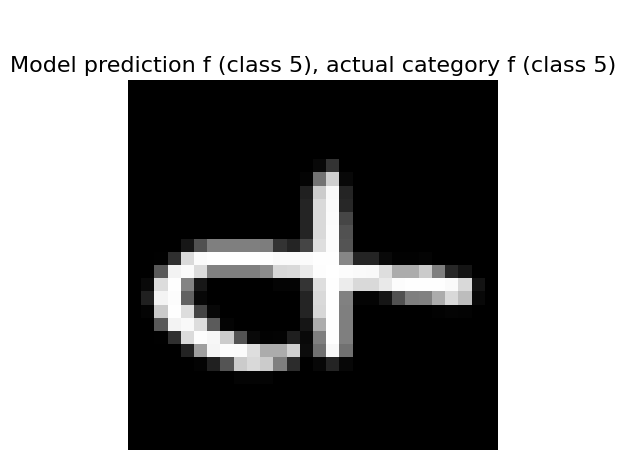

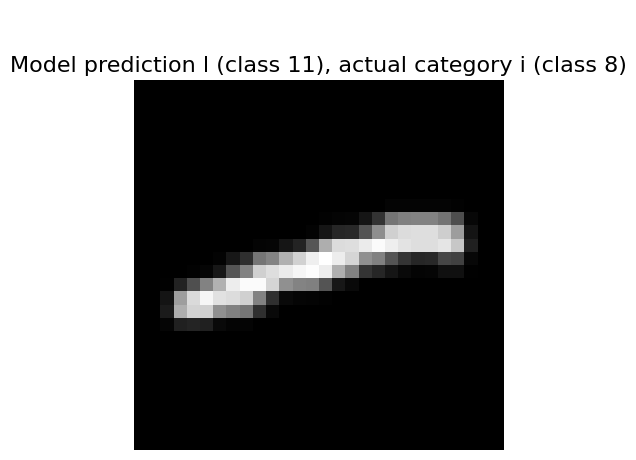

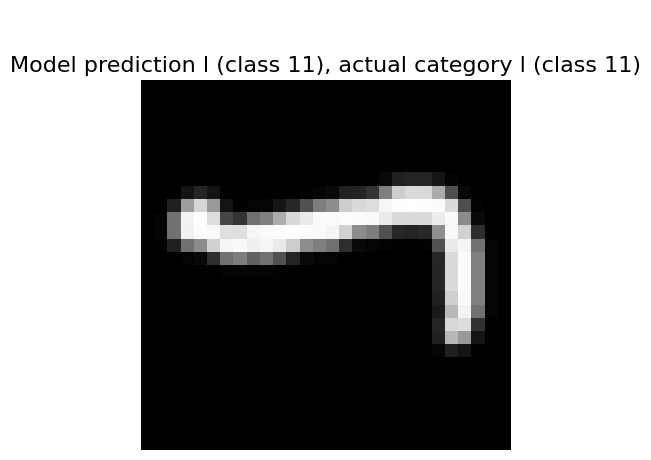

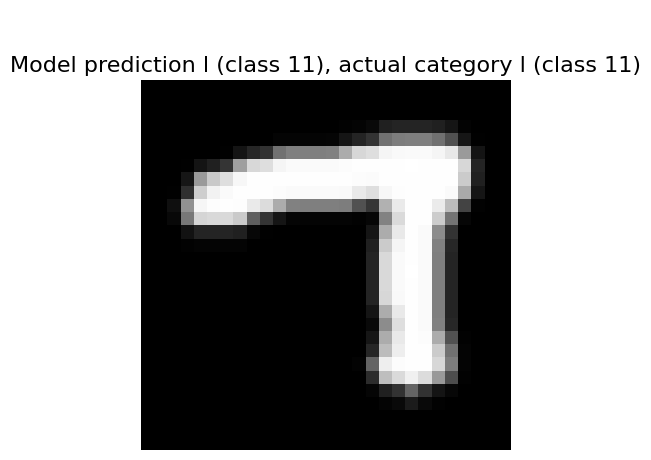

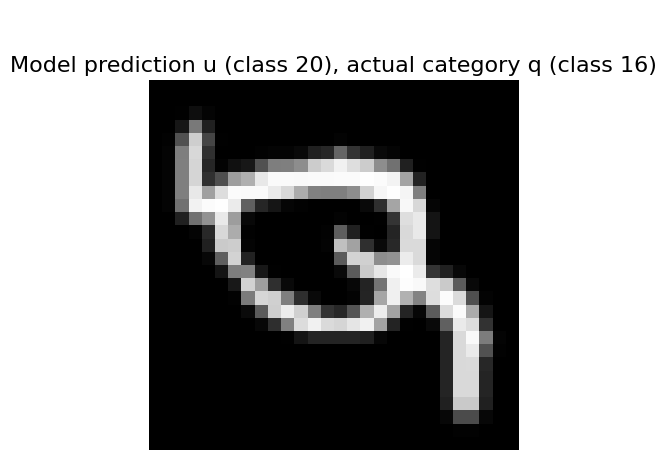

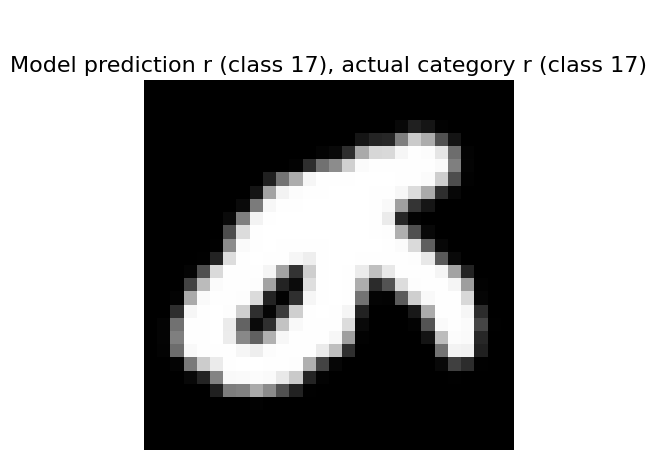

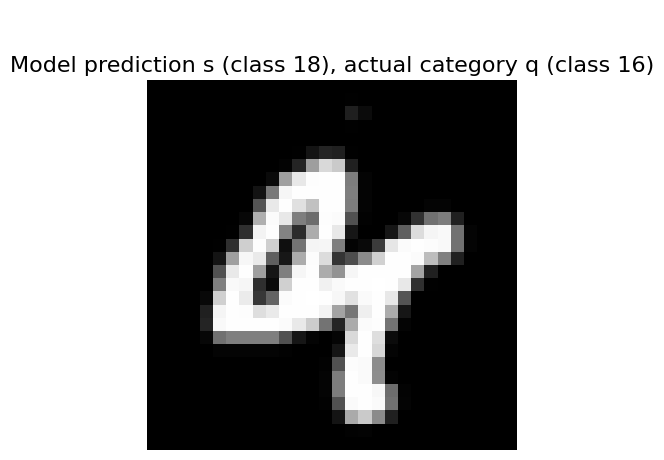

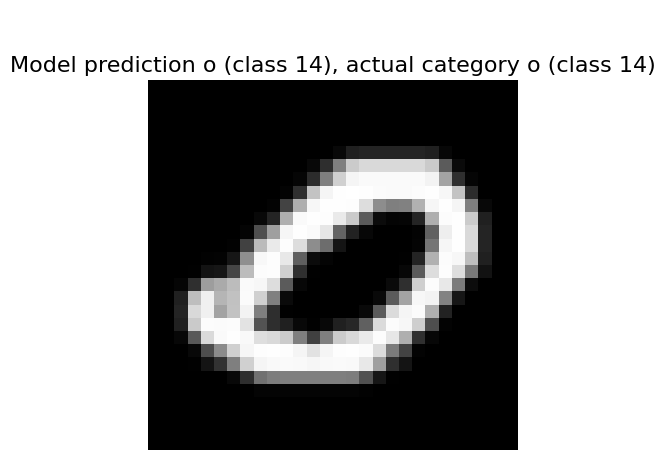

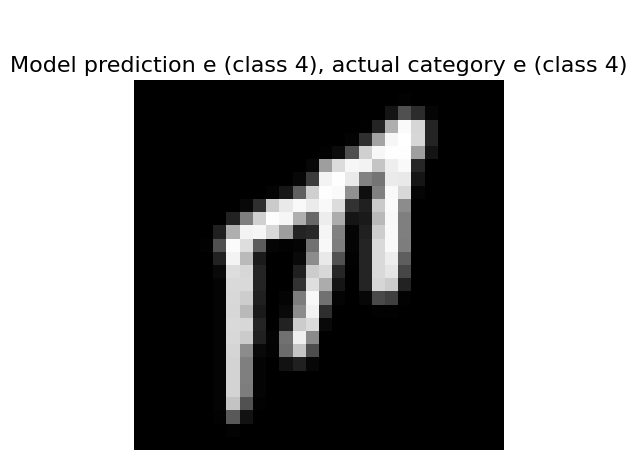

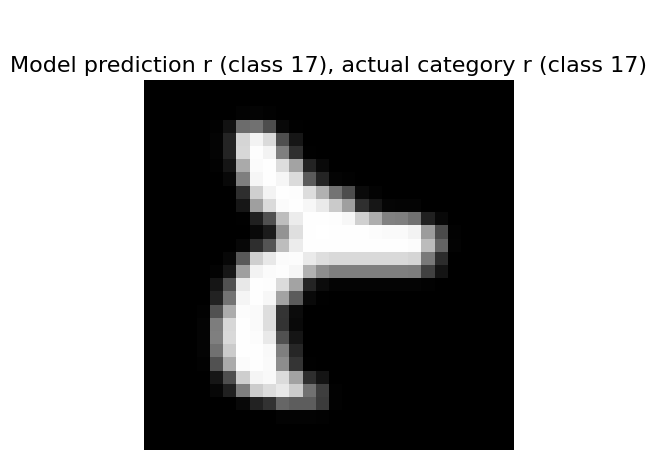

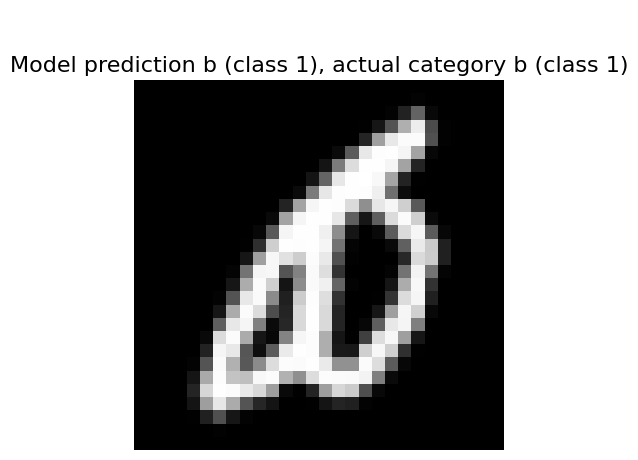

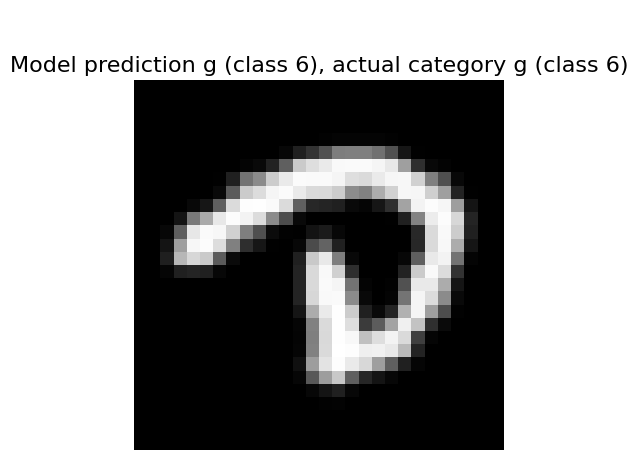

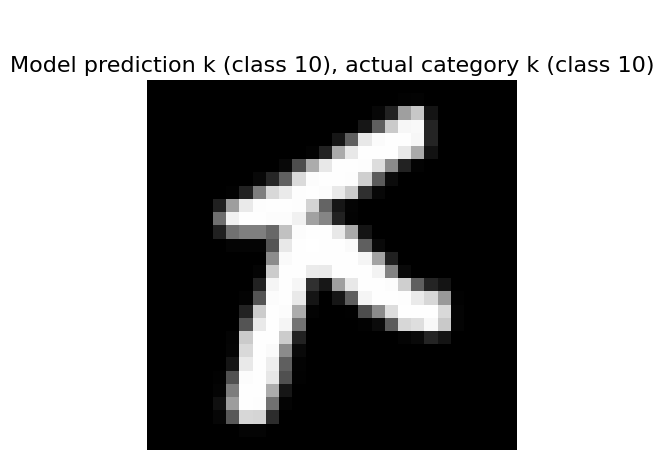

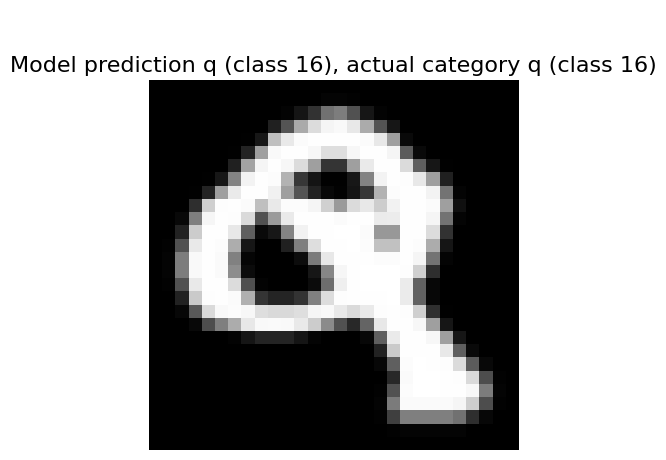

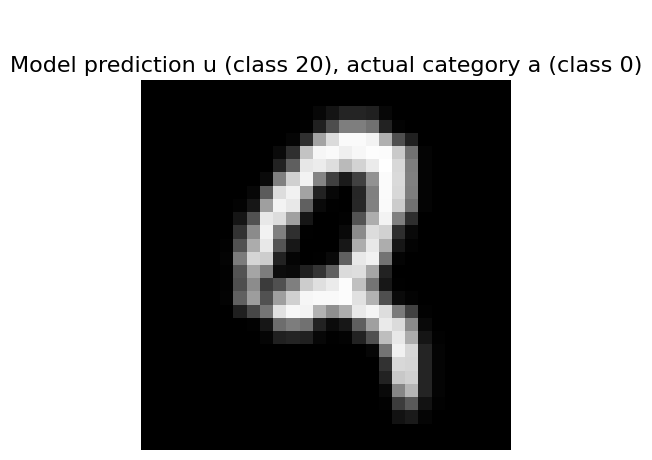

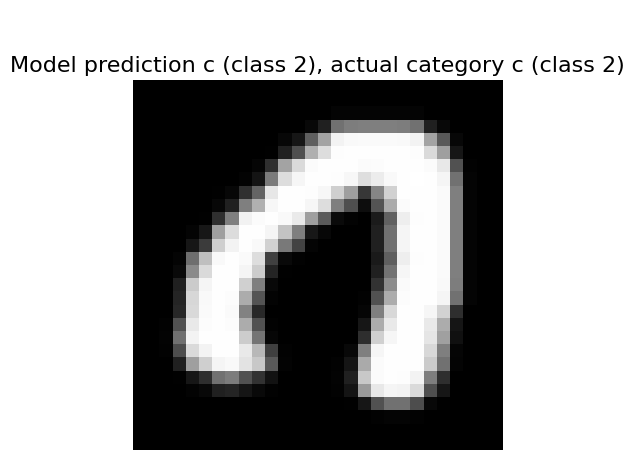

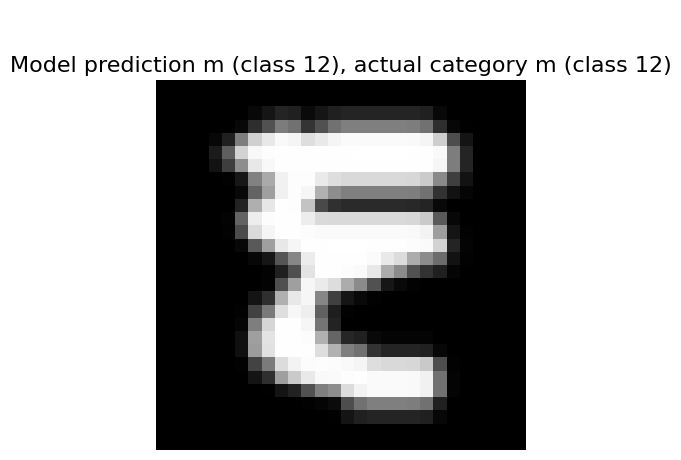

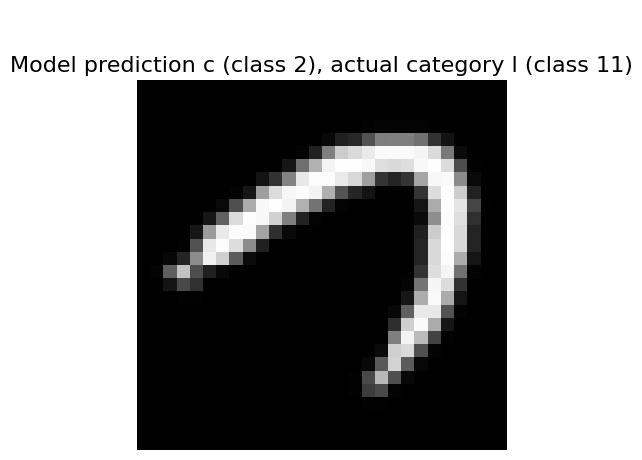

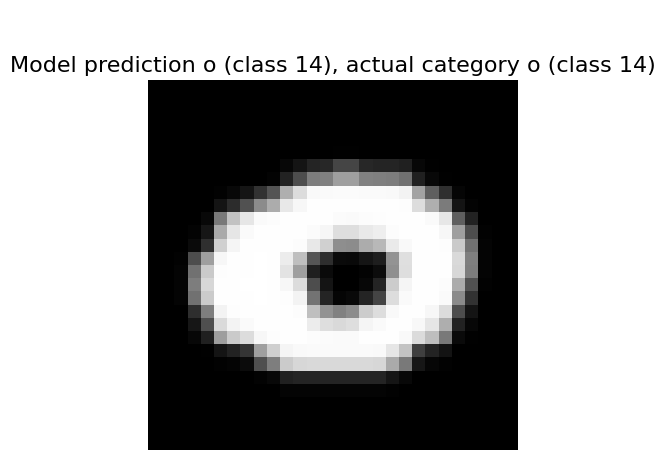

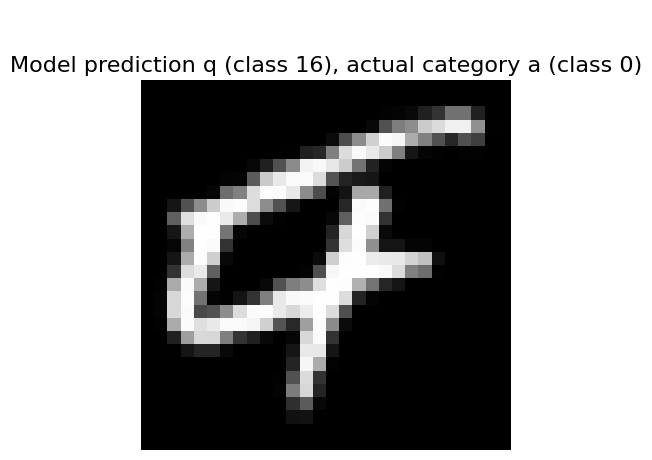

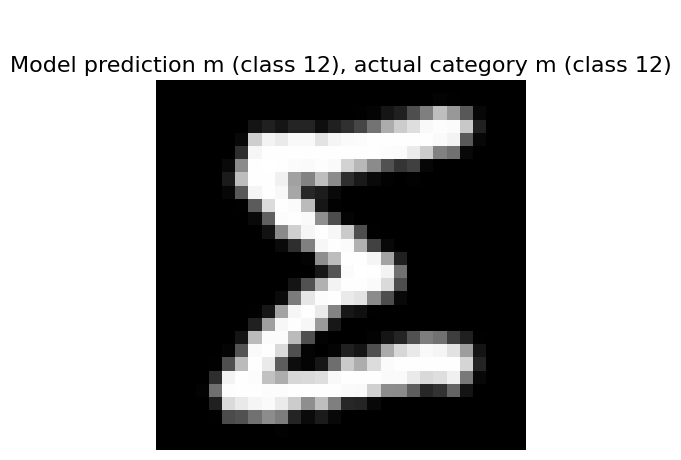

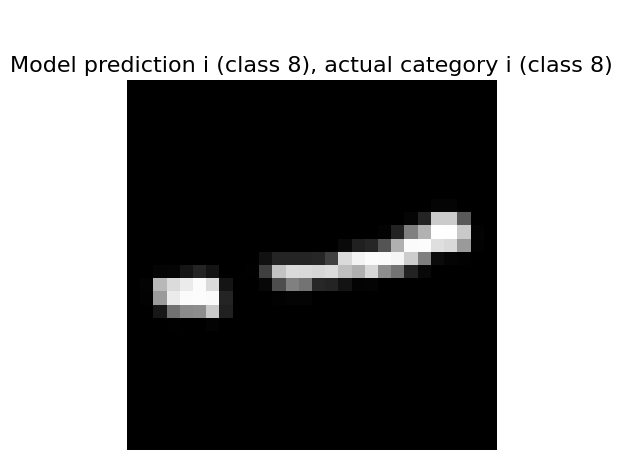

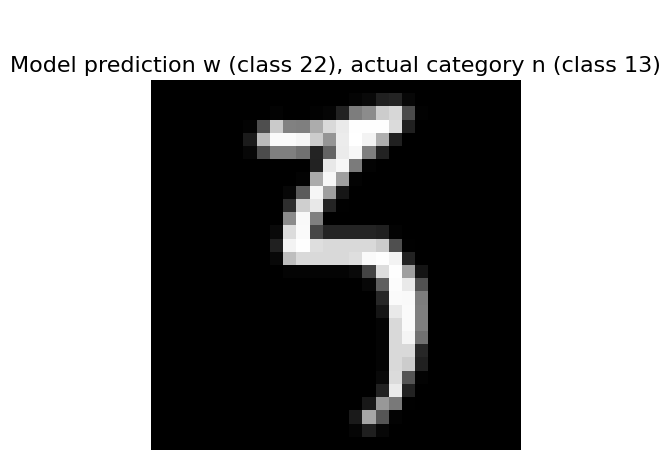

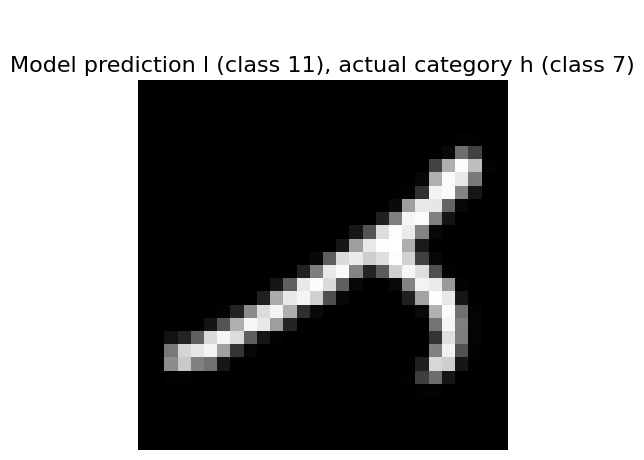

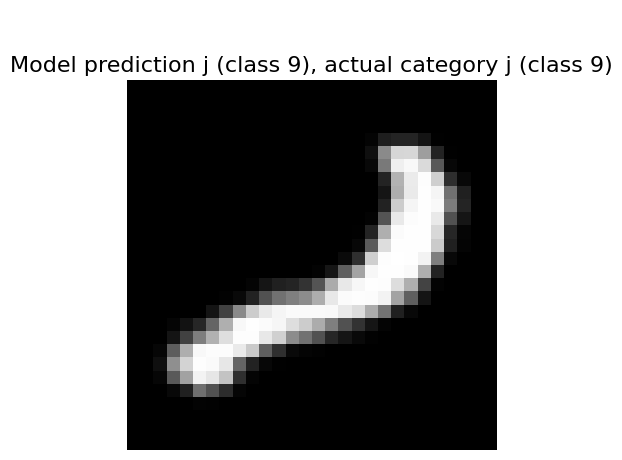

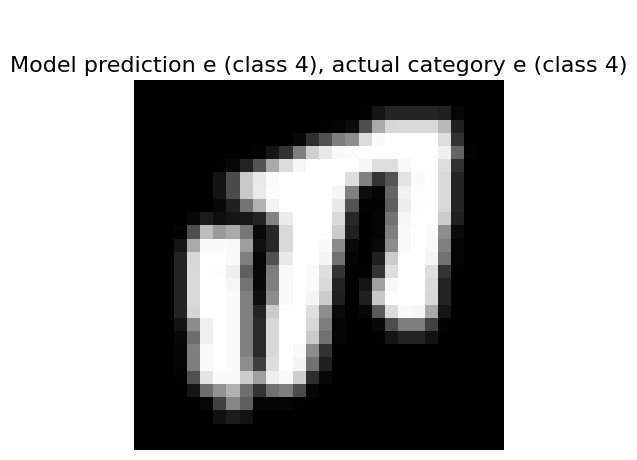

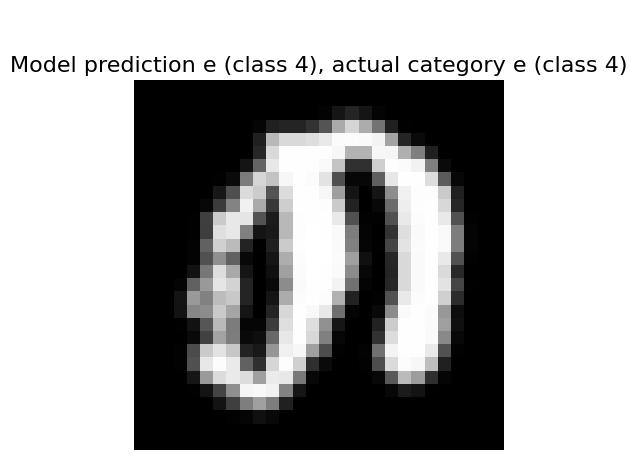

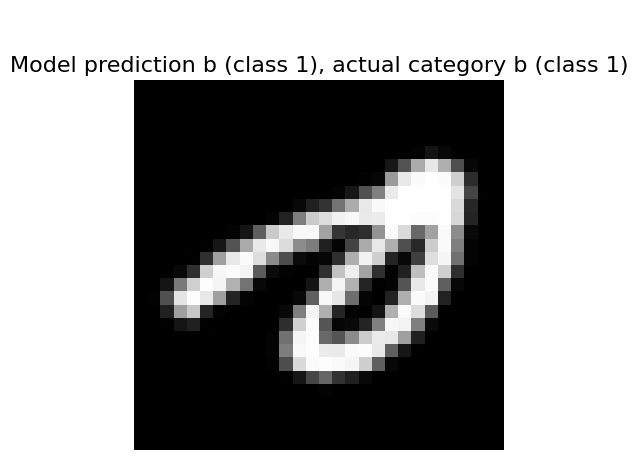

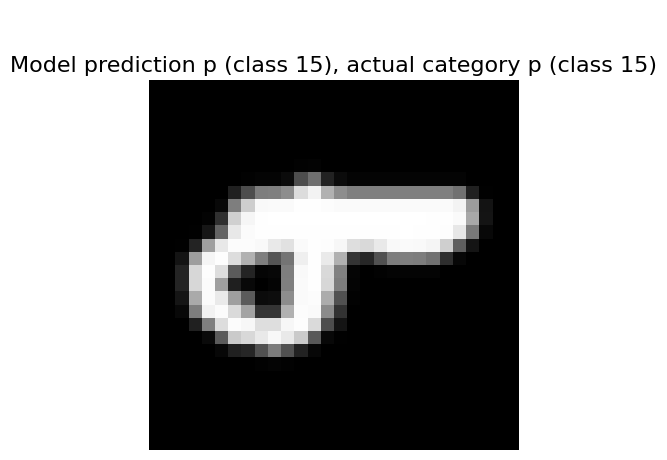

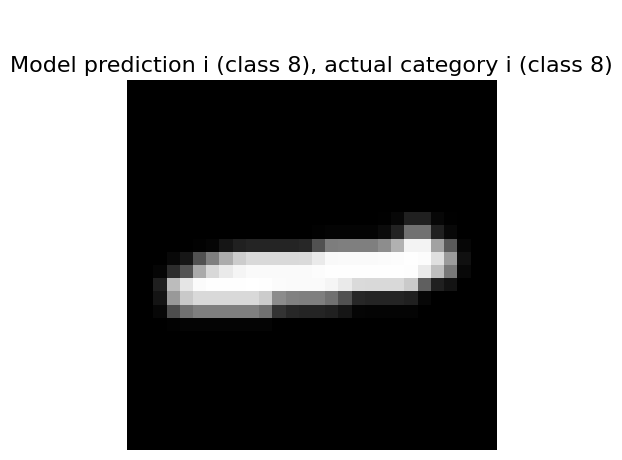

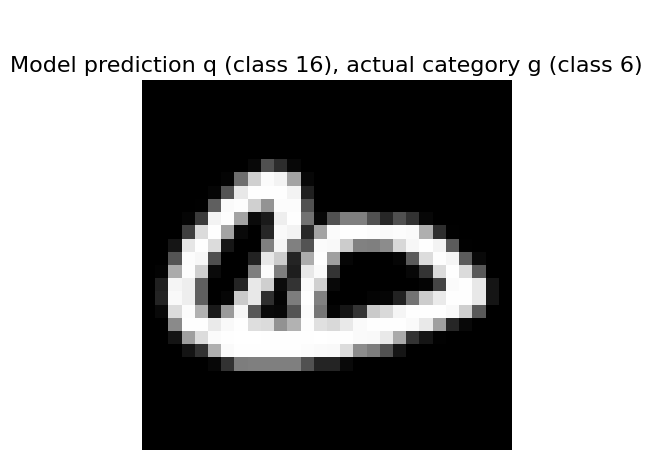

In [51]:
for i in range(64):
    predicted_class = np.argmax(predictions[i])
    actual_class = test_labels[i].long().item() - 1

    show(i, "Model prediction {} (class {}), actual category {} (class {})".format(
          classes[predicted_class], predicted_class,
          classes[actual_class], actual_class
    ))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy on test data: 0.8412730589904723


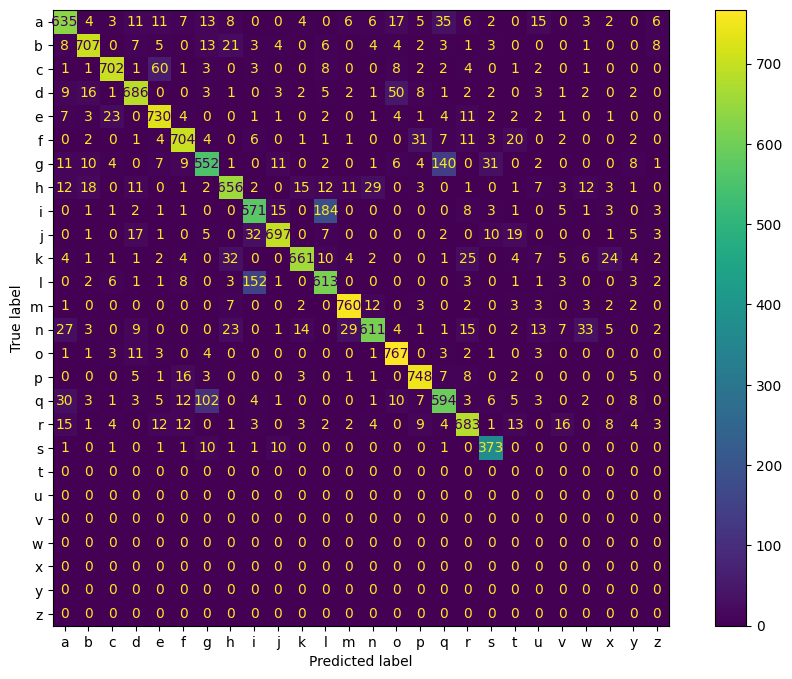

In [52]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dataloader:
        output = loaded_model.predict(inputs.numpy())

        output = np.argmax(output, axis = 1).astype("float64").tolist()
        y_pred.extend(output)

        labels = [ x-1 for x in labels.tolist()]
        y_true.extend(labels)

acc = accuracy_score(y_true, y_pred)
print("Accuracy on test data:", acc)

# Build confusion matrix
cm = confusion_matrix(y_true, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels = classes)
fig, ax = plt.subplots(figsize = (12, 8))
cmp.plot(ax = ax)

In [53]:
np.trace(cm) / len(test_dataset)

0.8412730589904723